In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from scipy.stats import levene
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import scipy
import statsmodels.stats.api as sms
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import het_white
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.compat import lzip
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima.arima import auto_arima

Celem projektu będzie analiza zobowiązań kredytowych w podziale na gospodarstwo domowe (ang. *Credit liabilities of households*) w Kanadzie w latach 2021-2023. Będziemy analizowali zobowiązania wynikające z zaciągnia kredytów niehipotecznych. Dane zostały pobrane z portalu <a href="https://www.statcan.gc.ca/fr/debut">Statistique Canada</a>, gdzie udostępniono dane dotyczące realiów życia w Kanadzie na wielu płaszczyznach. Zajmiemy się odpowiednio:
 <ul>
     <li>Ogólny zarys problemu</li>
     <li>Dekompozycja szeregu</li>
     <li>Odpowiedni dobór pierwszego modelu</li>
     <li>Modelewanie reszt</li>
     <li>Odpowiedni dobór drugiego modelu</li>
     <li>Porównanie obu modeli</li>
     <li>Predykcja</li>

## Ogólny zarys probelmu

In [2]:
kanada = pd.read_csv("kanada.csv")
kanada.Date = kanada.Date.astype('datetime64[ns]')

kredyty_nieh = kanada[kanada['Credit liabilities of households'] == "Non-mortgage loans"].drop('Credit liabilities of households', axis=1)
kredyty_nieh['Date'] = pd.to_datetime(kredyty_nieh['Date']) 
#

karta_kred = kanada[kanada['Credit liabilities of households'] == "Credit cards"].drop('Credit liabilities of households', axis=1)
karta_kred = karta_kred.set_index('Date')

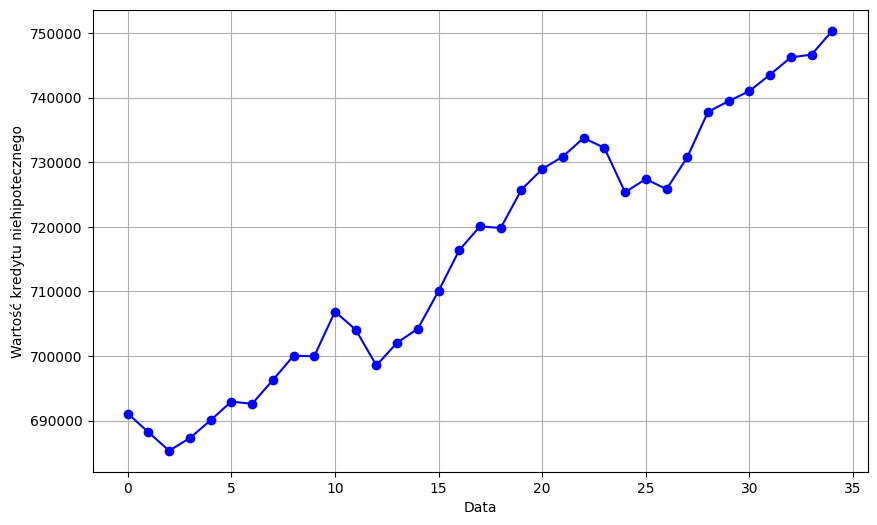

In [3]:
#| label: fig-overview
#| fig-cap: Rozkład średniej sumy pobieranych kredytów niehipotecznych

plt.figure(figsize=(10, 6))
plt.plot(kredyty_nieh.index, kredyty_nieh['VALUE'], marker='o', linestyle='-', color='b')
plt.xlabel('Data')
plt.ylabel('Wartość kredytu niehipotecznego')
plt.grid(True)
plt.show()

Powyższy wykres (patrz @fig-overview) pokazuje, że wraz niemalże z kolejnymi miesiącami wartość zobowiązań wobec banków Kanadyjczyków poprzez zaciągnaie kredytów niehipotecznych rosła.
Zakładając, że przeciętna wartość posiadanego kredytu w styczniu 2021 roku wynosiła około 690,000 CAD, natomiast pod koniec analizowanego okresu przypadającego na grudzień 2023 roku jest już to około 750,000 CAD. Oznacza to, że średni procentowy przyrost zadłużenia gospodarstwa domowego w Kanadzie w zadanym okresie wynosi około: 

In [4]:
str(round(750000/690000 * 100 - 100, 2)) + "%"

'8.7%'

Wykres poniżej (@fig-boxplot1) dobitnie obrazuje jak szybko rosły zobowiązania bankowe przeciętnego kandayjskiego gospodarstwa domowego na przestrzeni lat 2021-2023. 

In [5]:
a = kredyty_nieh.copy()
a["year"] = a.Date.dt.year
a["month"] = a.Date.dt.month

<Figure size 1200x600 with 0 Axes>

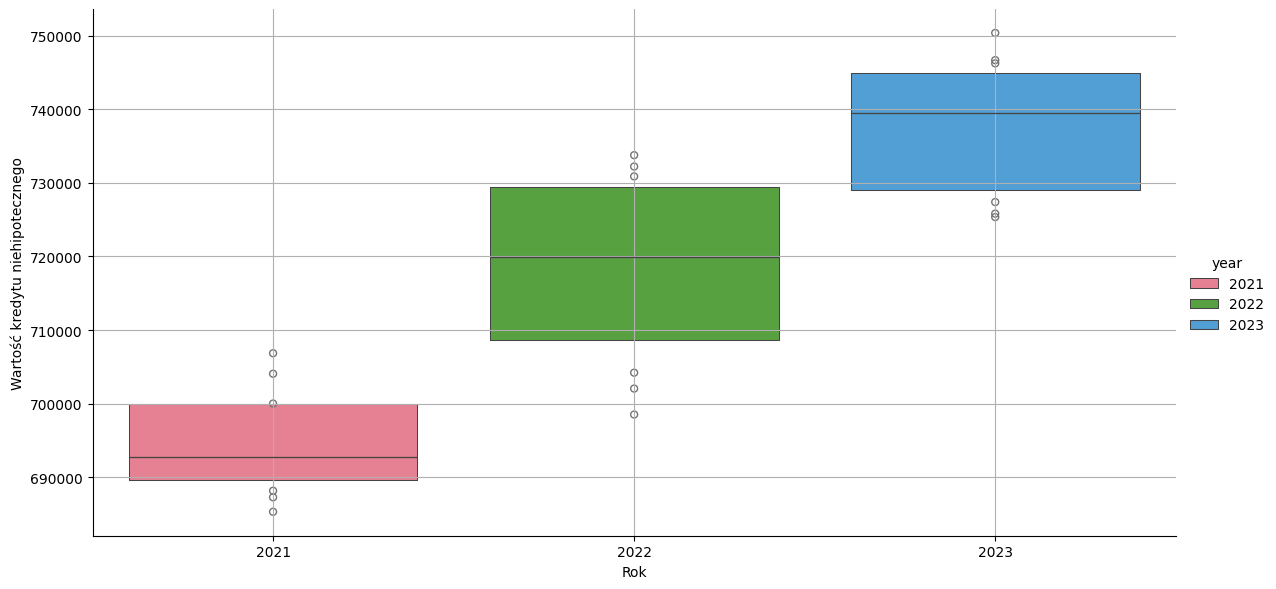

In [6]:
#| label: fig-boxplot1
#| fig-cap: Wykres boxplot posiadanego kredytu niehipotecznego w podziale na lata

custom_palette = sns.color_palette("husl", 3) 

plt.figure(figsize=(12, 6))
sns.catplot(data=a, x="year", y="VALUE", hue="year", kind="boxen", palette=custom_palette, height=6, aspect=2)
plt.xlabel('Rok')
plt.ylabel('Wartość kredytu niehipotecznego')
plt.grid(True)
plt.show()

Przyjrzymy sie temu jak wyglądał popyt na kredyty niehipoteczne w podziale na poszczególne miesiące:

c:\Users\spoko\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


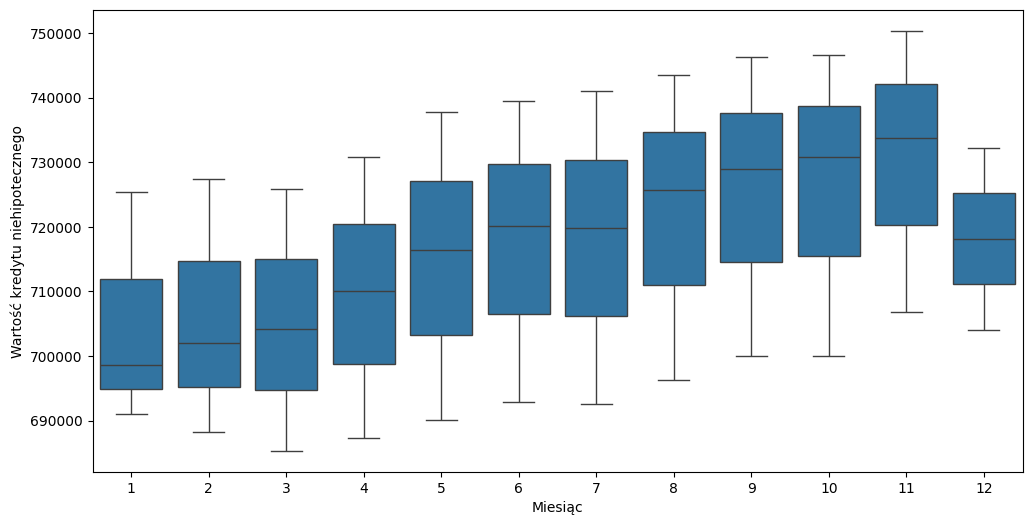

In [7]:
#| label: fig-boxplot2
#| fig-cap: Wykres boxplot dla sumy kredytu niehipotecznego w podziale na miesiące

plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='VALUE', data=a)  # Możesz zmienić paletę kolorów według potrzeb
plt.xlabel('Miesiąc')
plt.ylabel('Wartość kredytu niehipotecznego')
plt.show()

Zauważamy, że średnio w ciągu całego roku tendencje do zaciągania większych kredytów są dodatnie, z wyjątkiem grudnia, kiedy to średnia wartość zaciąganej pożyczki wyłamuje się z trendu i jest istotnie mniejsza od wartości z miesiąca poprzedniego. Mogłoby się wydawać, że w to właśnie w okresie świątecznym nastąpi *peak* kredytowy roku, zwłaszcza w świecie zachodnim, gdzie konsumpcjonizm jest wszechobecny. 

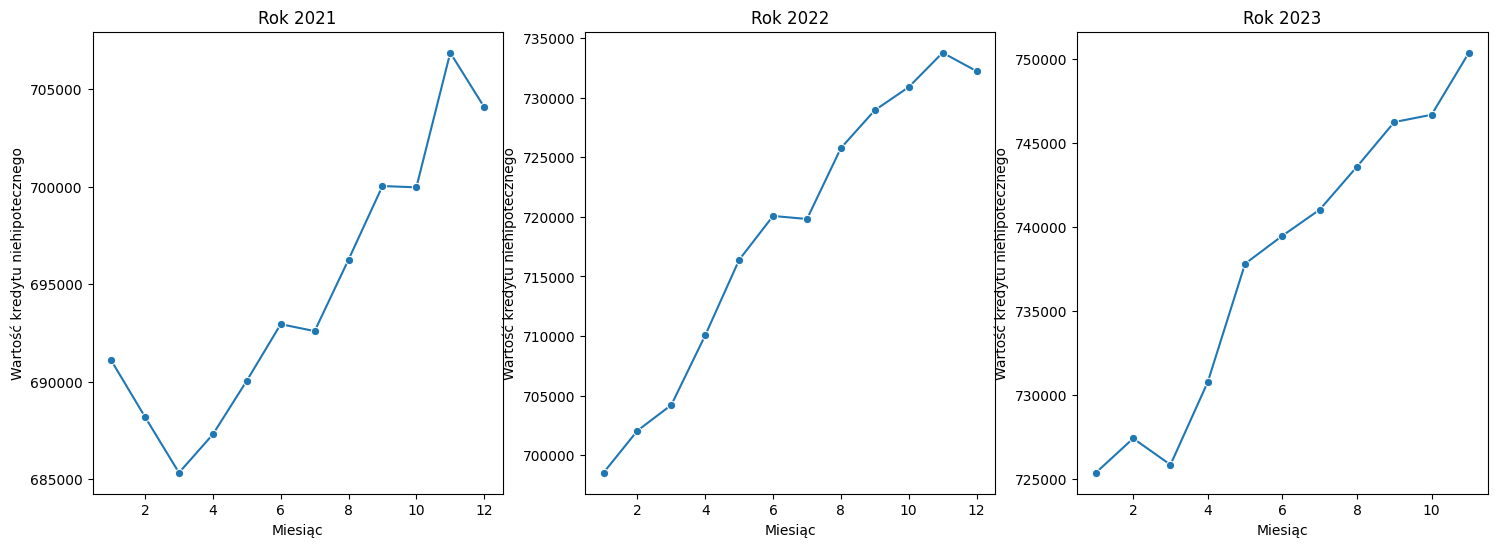

In [8]:
#| label: fig-linearity
#| fig-cap: Linowy wykres w podziale na lata

plt.figure(figsize=(18, 6))

years = a['year'].unique()
for i, year in enumerate(years, 1):
    plt.subplot(1, len(years), i)
    data_year = a[a['year'] == year]
    sns.lineplot(x='month', y='VALUE', data=data_year, marker='o')
    plt.title(f'Rok {year}')
    plt.xlabel('Miesiąc')
    plt.ylabel('Wartość kredytu niehipotecznego')


plt.show()

Dogłębniej identyfikujemy to zjawisko na powyższych wykresach (@fig-linearity). Co do grudnia roku 2023 nie jest on uwzględniony w danych, prawdopodobnie kanadyjski urząd statystyczny nie ukończył jeszcze raportu dla tego miesiąca.

Tabela poniżej przedstawia podstawowe statystki opisowe dla omawianego zbioru danych, w podziale na lata. Zgodnie ze wcześniejszymi założeniami trendu wzrostowego wraz z kolejnymi miesiącami, średnia dla każdego roku jest większa niż dla poprzedniego. Podobnie jest co do wartości odchylenia standardowego, odstępstwo obserwujemy w przypadku wartości tej statystki dla roku 2022, gdzie osiąga wartość maksymalną. Interpretacja może być następującą: w roku 2022 rynek mógł być niepewny ze względu na pewne wydarzenia w kraju/na świecie, przez co odstępstwa od wartości średniej dla tego roku były największe.   

In [9]:
grouped_data = a.groupby('year')['VALUE']
mean_values = round(grouped_data.mean(),2)
std_values = round(grouped_data.std(),2)

# Tworzenie tabelki
result_table = pd.DataFrame({
    'Rok': mean_values.index,
    'Średnia arytmetyczna': mean_values.values,
    'Odchylenie standardowe': std_values.values
})
result_table

,Rok,Średnia arytmetyczna,Odchylenie standardowe
0,2021,694562.67,6882.13
1,2022,718558.92,12384.76
2,2023,737666.55,8997.32


## Dekompozycja szeregu

Dekompozycja szeregu na jego poszczególne składowe: *trend*,*sezonowość* oraz *szum*, pozwoli dokładniej zbadać jego właściwości.

In [10]:
b = kredyty_nieh.copy()
b = b.set_index('Date')

Wykres trendu:

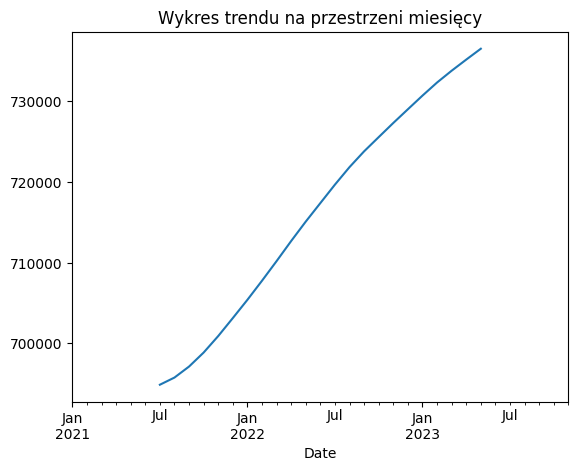

In [11]:
trend_kredyty_nieh = seasonal_decompose(b, period = 12).trend

trend_kredyty_nieh.plot()
plt.title("Wykres trendu na przestrzeni miesięcy")
plt.show()

Zauważamy ewidentną,dużą tendencję do wzrostu wartości posiadanego kredytu niehipotecznoego na gospodarstwo domowe w czasie omawianych lat.

Wykres sezonowości:

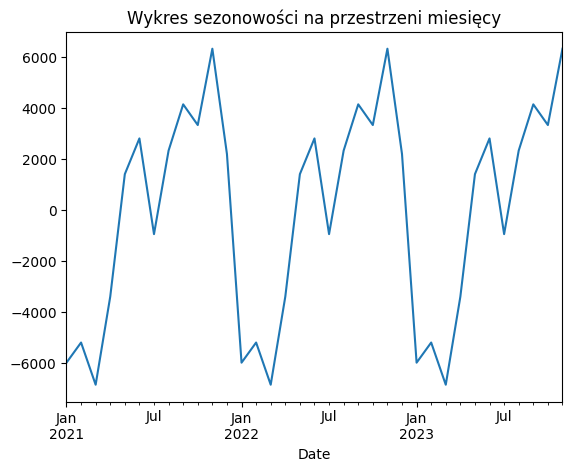

In [12]:
sezon_kredyty_nieh = seasonal_decompose(b, period = 12).seasonal

sezon_kredyty_nieh.plot()
plt.title("Wykres sezonowości na przestrzeni miesięcy")
plt.show()

Na powyższym wykresie identyfikujemy roczną sezonowość omawianego szeregu. Oznacza to, że w skali roku zmienne przyjmują podobne wartości.

Wykres reszt:

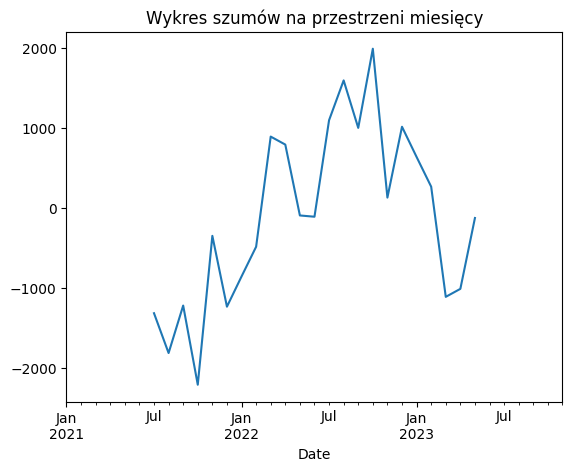

In [13]:
reszty_kredyty_nieh = seasonal_decompose(b, period = 12).resid

reszty_kredyty_nieh.plot()
plt.title("Wykres szumów na przestrzeni miesięcy")
plt.show()

Szum jest traktowany jako element trudny do przewidzenia i kontrolowania. 

## Dobór pierwszego modelu

Ze względu na występującą sezonowość roczną danych, możemy zbudować pierwszy model - model Holt'a Winters'a.

c:\Users\spoko\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\spoko\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\spoko\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\spoko\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


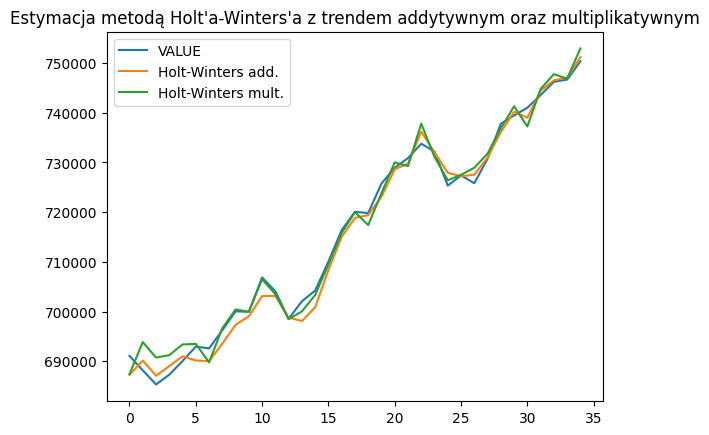

In [14]:
#| label: fig-holt
#| fig-cap: Metoda Holt'a-Winters'a

mdl_holt_mul = ExponentialSmoothing(kredyty_nieh['VALUE'],trend='mul', seasonal_periods = 12, seasonal = "mul").fit()
mdl_holt_add = ExponentialSmoothing(kredyty_nieh['VALUE'],trend='add', seasonal_periods = 12, seasonal = "add").fit()

kredyty_nieh['Holt-Winters add.'] = ExponentialSmoothing(kredyty_nieh['VALUE'],trend='add', seasonal_periods = 12, seasonal = "add").fit().fittedvalues
kredyty_nieh['Holt-Winters mult.'] = ExponentialSmoothing(kredyty_nieh['VALUE'],trend='mul', seasonal_periods = 12, seasonal = "mul").fit().fittedvalues
kredyty_nieh[['VALUE','Holt-Winters add.','Holt-Winters mult.']].plot(title="Estymacja metodą Holt'a-Winters'a z trendem addytywnym oraz multiplikatywnym")
plt.show()

Przedstawimy na wykresie jak metoda Holt'a-Winters'a estymuje analizowany szereg (@fig-holt). Obserwujemy stosunkowo dobre dopasowanie do danych teoretycznych.
Wykresy dla trendu addytywnego oraz multiplikatywnego nieco się od siebie różnią. Wybór lepszego modelu podejmujemy na podstawie mniejszej wartości indeksu AIC.

Wartość indeksu AIC modelu addytywnego:

In [15]:
round(mdl_holt_add.aic,2)

563.15

Wartość indeksu AIC modelu multiplikatywnego:

In [16]:
round(mdl_holt_mul.aic,2)

574.4

Model z trendem addytywnym okazuje się być nieco lepszy od modelu multiplikatywnego.

## Modelowanie reszt

Początkowo przeprowadzamy analizę autokorelacji reszt zbudowanego modelu. Posługujemy się testem *Durbin'a-Watson'a*. Wartość otrzymanej statystyki: 

In [17]:
print("Durbin-Watson Test statistic: "+ str(durbin_watson(mdl_holt_add.resid)))

Durbin-Watson Test statistic: 1.2345091693407397


Wartości statystyki testowej Durbin'a-Watson'a należą do przedziału [0; 4]. Uznaje się, że jeśli wartośc wyliczonej statystyki testowej nie jest z przedziału [1,5; 2,5] to autokorelacja jest znacząca. Oceniamy zatem, że reszty mododelu są skorelowane. 

Przeprowadzamy test *Dickey'a-Fuller'a* w celu zbadania stacjonarności:

In [18]:
print("Dickey-Fuller Test p-value: "+str(adfuller(kredyty_nieh.VALUE)[1]))

Dickey-Fuller Test p-value: 0.8235560642084352


Nie mamy podstaw do odrzucenia hipotezy zerowej świadczącej o braku stacjonarności szeregu -> szereg jest niestacjonarny.

Analizujemy normalność rozkładu reszt modelu. Przeprowadzamy test *Shapiro-Wilk'a*:

In [19]:
print("Shaprio-Wilk Test p-value: "+str(scipy.stats.shapiro(mdl_holt_add.resid)[1]))

Shaprio-Wilk Test p-value: 0.3002574165625425


Nie mamy podstaw do odrzucenia hipotezy zerowej o normalności rozkładu reszt modelu.

Badamy jednorodność reszt modelu przeprowadzając test *Goldfeld'a–Quandt'a*. Najpierw jednak narysujemy wykres standaryzowanych reszt modelu względem wartości dopasowanych, z którego możemy początkowo wywnioskować, czy zachodzi warunek jednorodności wariancji reszt.

In [20]:
#kredyty_nieh = kredyty_nieh.set_index(['Date']) 
residuals = mdl_holt_add.resid
std_residuals = residuals / np.std(residuals)

sqrt_std_residuals = np.sqrt(np.abs(std_residuals))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


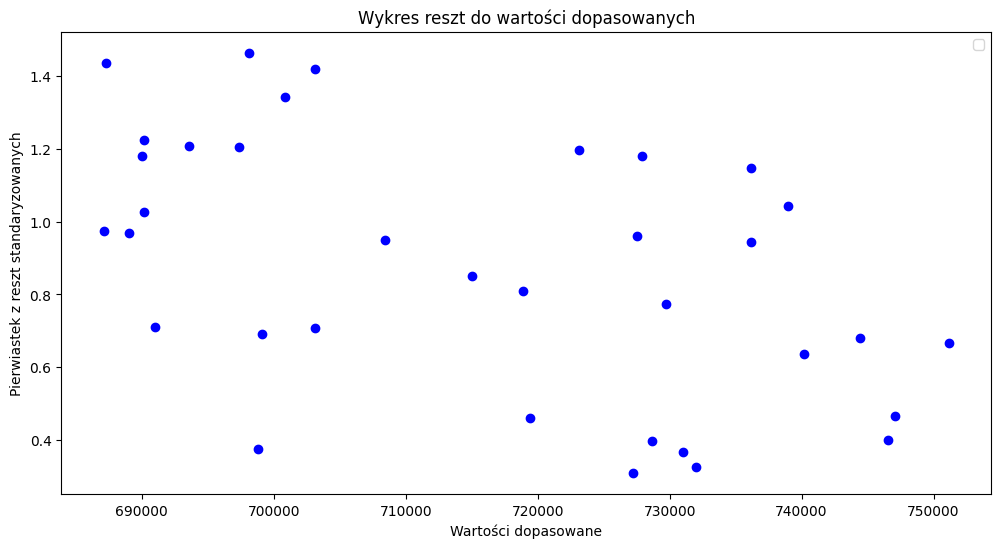

In [21]:
plt.figure(figsize=(12, 6))
plt.scatter(mdl_holt_add.fittedvalues, sqrt_std_residuals, marker='o', color='blue')
plt.xlabel('Wartości dopasowane')
plt.ylabel('Pierwiastek z reszt standaryzowanych')
plt.title('Wykres reszt do wartości dopasowanych')

plt.legend()  # Add legend for the zero line
plt.show()

Zauważamy, że rozkładają się stounkowo równoległe wzdłuż osi X (osi wartości dopasowanych). Możemy zatem wnioskować o homoskedastyczności reszt. Tezę tę poprzemy opierając decyzję na podstawie otrzymanego *p-value* wcześniej wspomnaiengo testu:

In [22]:
mdl_holt_add.model.exog =  np.column_stack((np.ones_like(kredyty_nieh.VALUE), kredyty_nieh.VALUE))

print("Goldfeld-Quandt Test p-value: "+str(sms.het_goldfeldquandt(mdl_holt_add.resid, mdl_holt_add.model.exog)[1]))

Goldfeld-Quandt Test p-value: 0.8297103454084707


Zgodnie z początkowym założeniem nie mamy podstaw do odrzucenia hipotezy o jednorodności wariancji reszt.

**Podsumowując.**Reszty modelu są skorelowane,szereg jest niestacjonarny oraz wykazuje się sezonowością w skali roku. Odpowiednim model prognozującym będzie model **SARIMA**. Model ten przyjmuje siedem parametrów (p,d,q)(P,D,Q)[s]. Do estymacji tych parametrów użujemy funckji `auto_arima()`, która tworzy różne kombinacje parametrów p,d,q,P,D,Q dla zadanego parametru s, oznaczającego okres sezonowości, minimalizując przy tym indeks *AIC*.
Podsumowanie zbudowanego modelu:

In [23]:
model_sarima = auto_arima(kredyty_nieh.VALUE, 
                   seasonal=True, 
                   m=12, 
                   suppress_warnings=True)

model_sarima = model_sarima.fit(kredyty_nieh.VALUE)

c:\Users\spoko\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,0)(1,1,1)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "c:\Users\spoko\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "c:\Users\spoko\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "c:\Users\spoko\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "c:\Users\spoko\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fi

In [24]:
model_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   35
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -215.895
Date:                            Tue, 05 Mar 2024   AIC                            443.791
Time:                                    18:35:59   BIC                            450.604
Sample:                                         0   HQIC                           445.504
                                             - 35                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1918.2663   5768.997      0.333      0.740   -9388.760    1.32e+04
ar.L1          0.6088      0.122      4.972      0.000       0.369       0.849
ma.L1         -0.6243      0.118     -5.301      0.000      -0.855      -0.393
ar.S.L12       0.5592      0.539      1.038      0.299      -0.497       1.615
ma.S.L12      -0.5279      0.506     -1.044      0.296      -1.519       0.463
sigma2      4.209e+06     50.151   8.39e+04      0.000    4.21e+06    4.21e+06
===================================================================================
Ljung-Box (L1) (Q):                   7.88   Jarque-Bera (JB):                 0.69
Prob(Q):                              0.01   Prob(JB):                         0.71
Heteroskedasticity (H):               9.03   Skew:                             0.31
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.77e+21. Standard errors may be unstable.
"""

Zwracamy uwagę na wartość indeksu *AIC* wynoszącą ~440.

Przystąpimy teraz do konfrontacji zbudowanego modelu SARIMA ze zmiennymi toaretycznymi. Spróbujemy przewidzeić jak wzrośnie/spanie suma kredytów niehipotecznych w przeliczeniu na kanadyjskie gospodarstwo domowe. Przewidzimy to dla kolejnych dwudziestuczterech miesięcy.

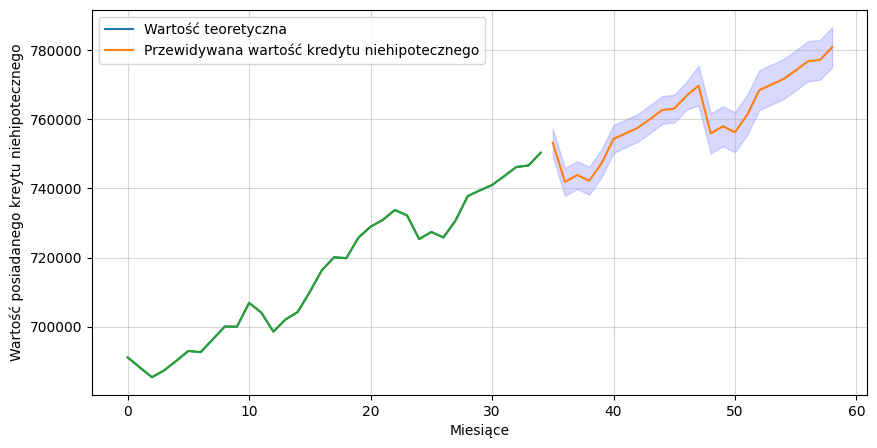

In [25]:
#| label: fig-sarima
#| fig-cap: Predykcja metodą SARIMA na kolejne 24 miesiące

forecast_auto, confidence_intervals_auto = model_sarima.predict(n_periods=24,
                                             return_conf_int=True)

ax = kredyty_nieh.VALUE[-12*4:].plot(figsize=(10,5))
forecast_auto.plot(ax=ax)
kredyty_nieh.VALUE.plot(ax=ax)
plt.fill_between(forecast_auto.index, 
                 confidence_intervals_auto[:,[0]].flatten(), 
                 confidence_intervals_auto[:,[1]].flatten(), 
                 color='blue',
                 alpha=0.15)
plt.legend(['Wartość teoretyczna',
           'Przewidywana wartość kredytu niehipotecznego'], 
           loc='upper left')
plt.xlabel('Miesiące')
plt.ylabel('Wartość posiadanego kreytu niehipotecznego')
plt.grid(alpha=0.5)
plt.show()

Jak obserwujemy na powyższym wykresie (@fig-sarima) odnotowujemy utrzymanie się trendu wzrostowego posiadanej sumy kredytu niehipotecznego. Dla predykcji na wykresie zostały naniesione przedziały ufnosci.